 # MLP example using PySNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

from pysnn.connection import Linear
from pysnn.neuron import LIFNeuron, Input
from pysnn.learning import MSTDPET
from pysnn.encoding import PoissonEncoder
from pysnn.network import SNNNetwork
from pysnn.datasets import AND, BooleanNoise, Intensity

 ## Parameter defintions

In [2]:
# Architecture
n_in = 10
n_hidden = 5
n_out = 1

# Data
duration = 200
intensity = 50
num_workers = 0
batch_size = 1

# Neuronal Dynamics
thresh = 1.0
v_rest = 0
alpha_v = 10
tau_v = 10
alpha_t = 10
tau_t = 10
duration_refrac = 2
dt = 1
delay = 2
i_dynamics = (dt, alpha_t, tau_t, "exponential")
n_dynamics = (thresh, v_rest, alpha_v, alpha_v, dt, duration_refrac, tau_v, tau_t, "exponential")
c_dynamics = (batch_size, dt, delay)

# Learning
epochs = 100
lr = 0.1
w_init = 0.8
a = 0.0

 ## Network definition
 The API is mostly the same as for regular PyTorch. The main differences are that layers are composed of a `Neuron` and `Connection` type,
 and the layer has to be added to the network by calling the `add_layer` method. Lastly, all objects return both a
 spike (or activation potential) object and a trace object.

 NOTE: This network shows that PySNN is capable of defining cyclic graphs, since there is a feedback connection from neuron 2 to neuron 1, and recurrent connections on both layers. This network is by no means an example of a well performing network.

In [3]:
class Network(SNNNetwork):
    r"""Example of a cyclic graph containing feedback and recurrent connections.
    
    This network is by no means an example of a well performing network.
    """

    def __init__(self):
        super(Network, self).__init__()

        # Input
        self.input = Input((batch_size, 1, n_in), *i_dynamics)

        # Layer 1
        self.mlp1_c = Linear(n_in, n_hidden, *c_dynamics)
        self.mlp1_c.reset_weights(distribution="uniform")  # initialize uniform between 0 and 1
        self.neuron1 = LIFNeuron((batch_size, 1, n_hidden), *n_dynamics)
        self.add_layer("fc1", self.mlp1_c, self.neuron1)

        # Recurrent connection for neuron1
        self.mlp1_rec = Linear(n_hidden, n_hidden, *c_dynamics)
        self.add_layer("fc1_rec", self.mlp1_rec, self.neuron1)

        # Layer 2
        self.mlp2_c = Linear(n_hidden, n_out, *c_dynamics)
        self.mlp2_c.reset_weights(distribution="uniform")
        self.neuron2 = LIFNeuron((batch_size, 1, n_out), *n_dynamics)
        self.add_layer("fc2", self.mlp2_c, self.neuron2)

        # Recurrent connection for neuron 2
        self.mlp2_rec = Linear(n_out, n_out, *c_dynamics)
        self.add_layer("fc2_rec", self.mlp2_rec, self.neuron2)

        # Feedback connection from neuron 2 to neuron 1
        self.mlp2_prev = Linear(n_out, n_hidden, *c_dynamics)
        self.add_layer("fc2_back", self.mlp2_prev, self.neuron1)

    def forward(self, input):
        x, t = self.input(input)

        # Layer 1
        x_prev, _ = self.mlp2_prev(self.neuron2.spikes, self.neuron2.trace)
        x_rec, _ = self.mlp1_rec(self.neuron1.spikes, self.neuron1.trace)
        x_forw, _ = self.mlp1_c(x, t)
        x, t = self.neuron1([x_forw, x_rec])

        # Layer out
        x_rec, _ =self.mlp2_rec(self.neuron2.spikes, self.neuron2.trace)
        x_forw, _ = self.mlp2_c(x, t)
        x, t = self.neuron2([x_rec, x_forw])

        return x, t

 ## Dataset
 Simple Boolean AND dataset, generated to match the input dimensions of the network.

In [4]:
data_transform = transforms.Compose(
    [
        # BooleanNoise(0.2, 0.8),
        Intensity(intensity)
    ]
)
lbl_transform = transforms.Lambda(lambda x: x * intensity)

train_dataset = AND(
    data_encoder=PoissonEncoder(duration, dt),
    data_transform=data_transform,
    lbl_transform=lbl_transform,
    repeats=n_in / 2,
)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

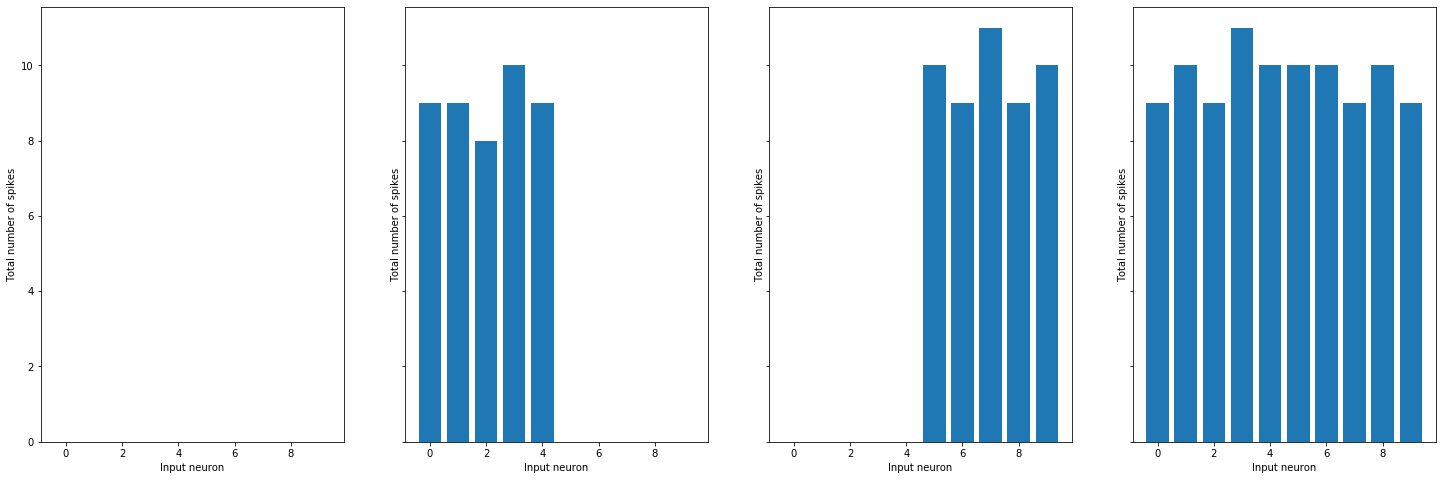

In [5]:
# Visualize input samples
_, axes = plt.subplots(1, 4, sharey=True, figsize=(25, 8))
for s in range(len(train_dataset)):
    sample = train_dataset[s][0]  # Drop label
    sample = sample.sum(-1).numpy()  # Total spike by summing over time dimension
    sample = np.squeeze(sample)
    axes[s].bar(range(len(sample)), sample)
    axes[s].set_ylabel("Total number of spikes")
    axes[s].set_xlabel("Input neuron")

## Training

In [6]:
device = torch.device("cpu")
net = Network()

# Learning rule definition
layers = net.layer_state_dict()
learning_rule = MSTDPET(layers, 1, 1, lr, np.exp(-1/10))

# Training loop
for _ in tqdm(range(epochs)):
    for batch in train_dataloader:
        sample, label = batch

        # Iterate over input's time dimension
        for idx in range(sample.shape[-1]):
            input = sample[:, :, :, idx]
            spike_net, _ = net(input)
            
            # Determine reward, provide reward of 1 for desired behaviour, 0 otherwise.
            # For positive samples (simulating an AND gate) spike as often as possible, for negative samples spike as little as possible.
            if spike_net.long().view(-1) == label:
                reward = 1
            else:
                reward = 0

            # Perform a single step of the learning rule
            learning_rule.step(reward)

        # Reset network state (e.g. voltage, trace, spikes)
        net.reset_state()

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


## Generate Data for Visualization

In [7]:
out_spikes = []
out_voltage = []
out_trace = []

for batch in train_dataloader:
    single_out_s = []
    single_out_v = []
    single_out_t = []
    sample, _ = batch

    # Iterate over input's time dimension
    for idx in range(sample.shape[-1]):
        input = sample[:, :, :, idx]
        spike_net, trace_net = net(input)

        # Single timestep results logging
        single_out_s.append(spike_net.clone())
        single_out_t.append(trace_net.clone())
        single_out_v.append(net.neuron2.v_cell.clone())  # Clone the voltage to make a copy of the value instead of using a pointer to memory

    # Store batch results
    out_spikes.append(torch.stack(single_out_s, dim=-1).view(-1))
    out_voltage.append(torch.stack(single_out_v, dim=-1).view(-1))
    out_trace.append(torch.stack(single_out_t, dim=-1).view(-1))

    # Reset network state (e.g. voltage, trace, spikes)
    net.reset_state()

### Visualize output neuron state over time

In the voltage plots the peaks never reach the voltage of 1, this is because the network has already reset the voltage of the spiking neurons during the forward pass. Thus it is not possible to register the exact voltage surpassing the threshold.

Note that the output is pushing towards maximum firing rate due to the reciprocal connection in the network. These results do not mean anything.

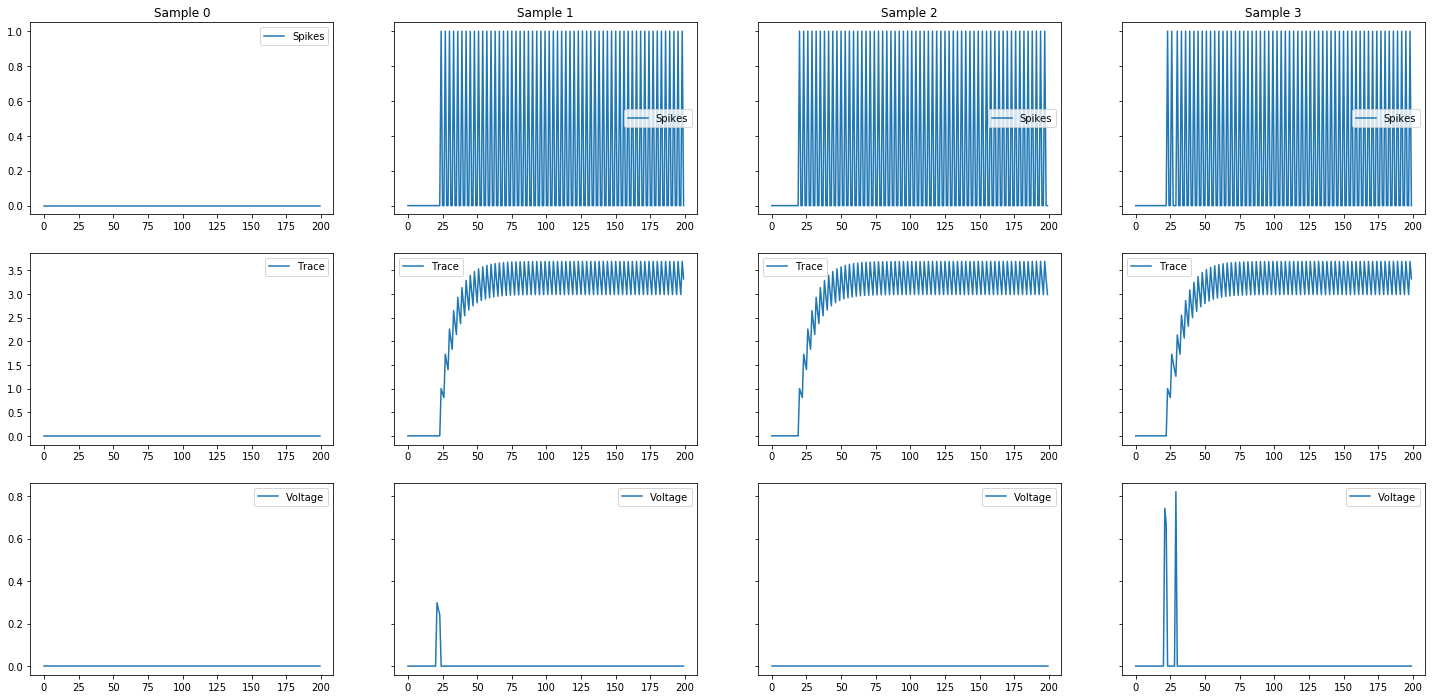

In [8]:
_, axes = plt.subplots(3, 4, sharey="row", figsize=(25, 12))

# Process every sample separately
for s in range(len(out_spikes)):
    ax_col = axes[:, s]
    spikes = out_spikes[s]
    voltage = out_voltage[s]
    trace = out_trace[s]
    data_combined = [spikes, trace, voltage]
    names = ["Spikes", "Trace", "Voltage"]

    # Set column titles
    ax_col[0].set_title(f"Sample {s}")
    
    # Plot all states
    for ax, data, name in zip(ax_col, data_combined, names):
        ax.plot(data, label=name)
        ax.legend()